In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py

import tensorflow as tf
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from time import time
from icecream import ic

from msfm.utils import tfrecords, analysis, parameters
from msfm import fiducial_pipeline
from msfm.utils.input_output import read_yaml

In [3]:
conf_dir = "../../configs/config.yaml"
conf = read_yaml(conf_dir)

# repo_dir = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model"
repo_dir = "/Users/arne/git/multiprobe-simulation-forward-model"

# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v1/fiducial/DESy3_fiducial_???.tfrecord"
tfr_pattern = "/Users/arne/data/DESY3/tfrecords/v2/DESy3_fiducial_000.tfrecord"

params = ["Om", "s8", "Aia"]
pert_labels = parameters.get_fiducial_perturbation_labels(params)
n_perts = len(pert_labels)
print(n_perts, pert_labels)

n_z_bins = 4

batch_size = 4
examples_shuffle_buffer = 10
n_readers = 1
n_prefetch = 3

7 ['fiducial', 'delta_Om_m', 'delta_Om_p', 'delta_s8_m', 'delta_s8_p', 'delta_Aia_m', 'delta_Aia_p']


In [4]:
fiducial_dset = fiducial_pipeline.get_fiducial_dset(
    tfr_pattern,
    pert_labels,
    batch_size,
    conf=None,
    i_noise=0,
    n_readers=n_readers,
    n_prefetch=n_prefetch,
    examples_shuffle_buffer=examples_shuffle_buffer,
)

23-02-22 12:35:17 fiducial_pip INF   Starting to generate the fiducial training set for i_noise = 0 
23-02-22 12:35:17  analysis.py INF   Loaded the config 
23-02-22 12:35:17  analysis.py INF   Loaded the pixel file 
23-02-22 12:35:17  analysis.py INF   Loaded the config 
23-02-22 12:35:17  analysis.py INF   Loaded the pixel file 
Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-02-22 12:35:17.710136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-22 12:35:17.710287: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23-02-22 12:35:18 tfrecords.py WAR   Tracing parse_inverse_fiducial 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the func

2023-02-22 12:35:21.093638: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


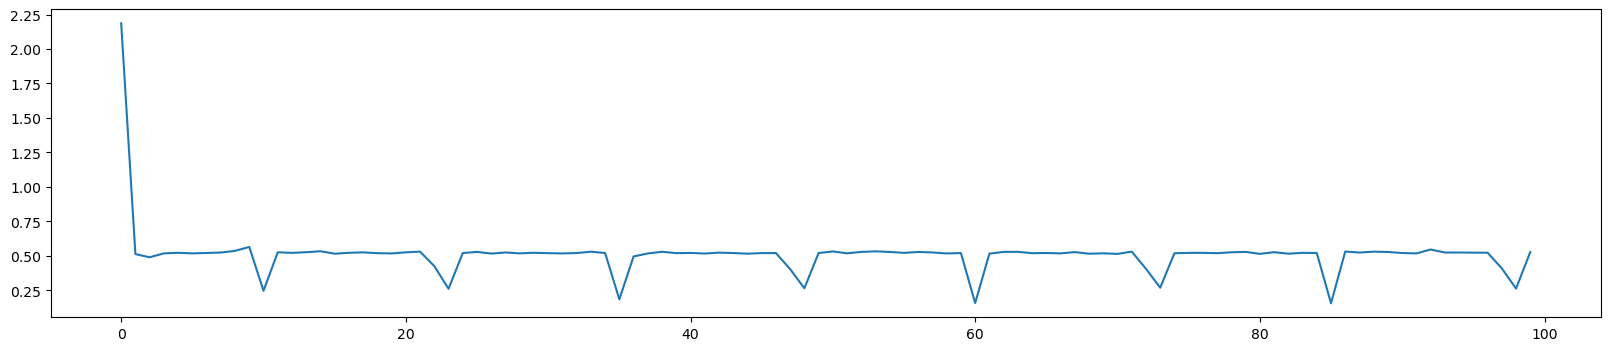

In [5]:
t0 = time()
delta_t = []
for x in fiducial_dset.take(100):
    t1 = time()
    delta_t.append(t1 - t0)
    t0 = t1

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(delta_t)

In [7]:
multi_noise_dset = fiducial_pipeline.get_fiducial_multi_noise_dset(
    tfr_pattern,
    pert_labels,
    batch_size,
    conf=None,
    n_noise=3,
    n_readers=n_readers,
    n_prefetch=n_prefetch,
    examples_shuffle_buffer=examples_shuffle_buffer,
)

23-02-22 12:36:50 fiducial_pip INF   Starting to generate the fiducial training set for i_noise = 0 
23-02-22 12:36:50  analysis.py INF   Loaded the config 
23-02-22 12:36:50  analysis.py INF   Loaded the pixel file 
23-02-22 12:36:50  analysis.py INF   Loaded the config 
23-02-22 12:36:50  analysis.py INF   Loaded the pixel file 
23-02-22 12:36:50 tfrecords.py WAR   Tracing parse_inverse_fiducial 
23-02-22 12:36:50  analysis.py INF   Loaded the config 
23-02-22 12:36:50 fiducial_pip WAR   Tracing dset_add_bias 
23-02-22 12:36:50 fiducial_pip WAR   Tracing dset_add_noise 
23-02-22 12:36:50 fiducial_pip WAR   Tracing dset_concat_perts 
23-02-22 12:36:50 fiducial_pip INF   Successfully generated the fiducial training set with element_spec (TensorSpec(shape=(28, 463872, 4), dtype=tf.float32, name=None), (TensorSpec(shape=(4,), dtype=tf.int64, name=None), TensorSpec(shape=(4,), dtype=tf.int32, name=None))) for i_noise = 0 
23-02-22 12:36:50 fiducial_pip INF   Starting to generate the fiduc

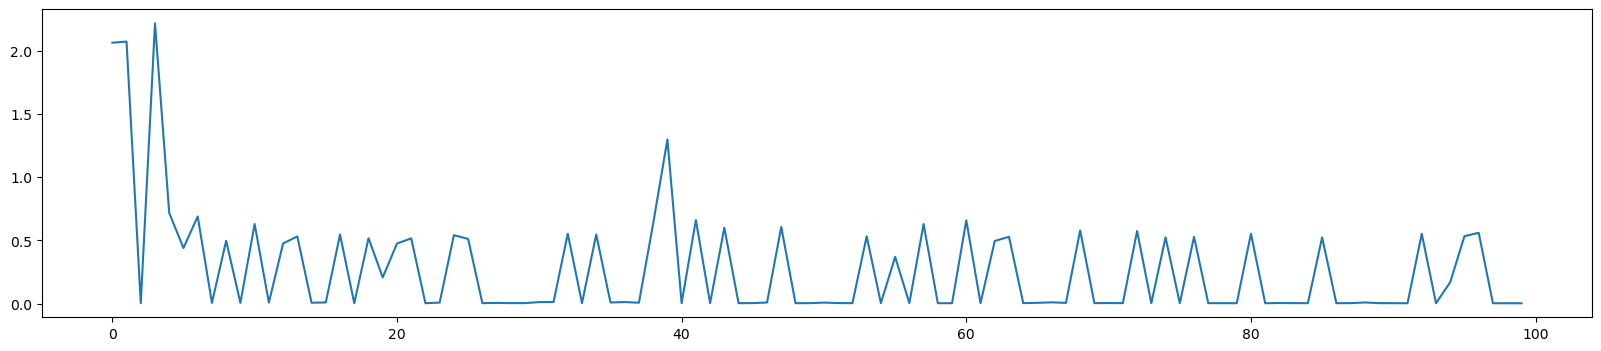

In [8]:
t0 = time()
delta_t = []
for x in multi_noise_dset.take(100):
    t1 = time()
    delta_t.append(t1 - t0)
    t0 = t1

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(delta_t)

### pick an example batch

In [9]:
for x in fiducial_dset.take(1):
    x
    
print(x)

(<tf.Tensor: shape=(28, 463872, 4), dtype=float32, numpy=
array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0

### check the mask

In [12]:
data_vec_pix, _, _, tomo_patches_pix, tomo_corresponding_pix = analysis.load_pixel_file(conf)

kgs = x[0][0]
print(kgs.shape)

print([np.sum(kgs[:,i] != 0) for i in range(4)])
print([len(patches_pix[0]) for patches_pix in tomo_patches_pix])
print([len(patches_pix) for patches_pix in tomo_corresponding_pix])

23-02-22 12:37:52  analysis.py INF   Loaded the config 
23-02-22 12:37:52  analysis.py INF   Loaded the pixel file 
(463872, 4)
[371012, 370979, 370982, 370671]
[371012, 370979, 370982, 370671]
[371012, 370979, 370982, 370671]


# plotting

In [13]:
pix_file = "../../data/DESY3_pixels_512.h5"
with h5py.File(pix_file, "r") as f:
    data_vec_pix = f["metacal/map_cut_outs/data_vec_ids"][:]
    non_tomo_patches_pix = f["metacal/masks/RING/non_tomo"][:]
    
n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]

### check the masking

(463872,)
(463872,)
(463872,)
(463872,)


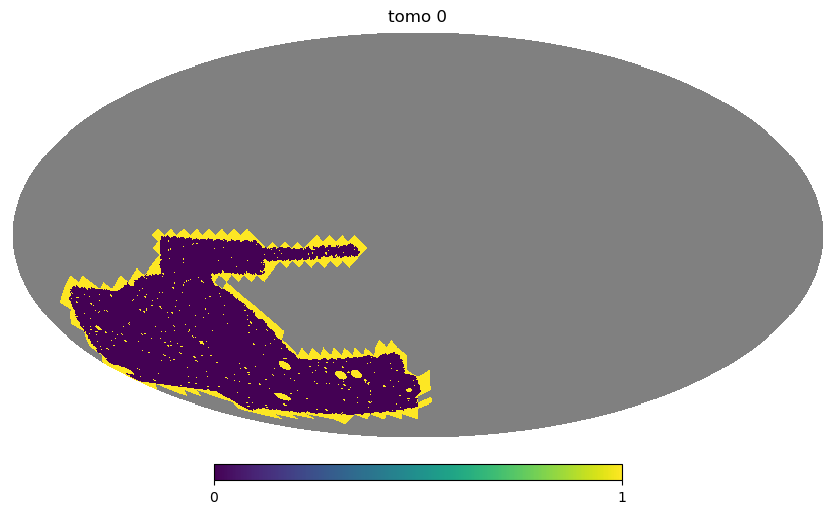

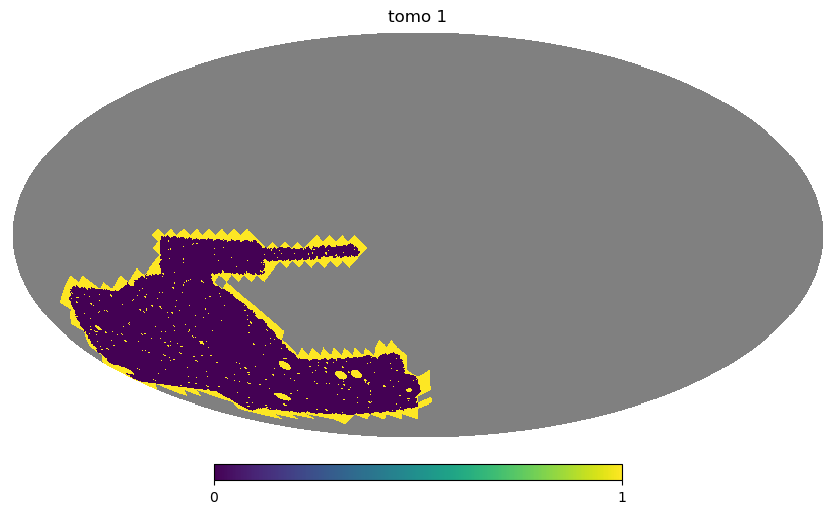

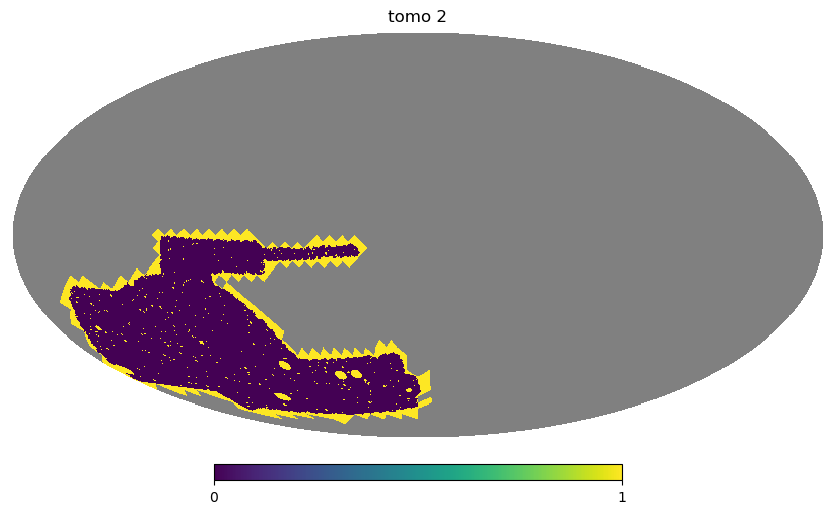

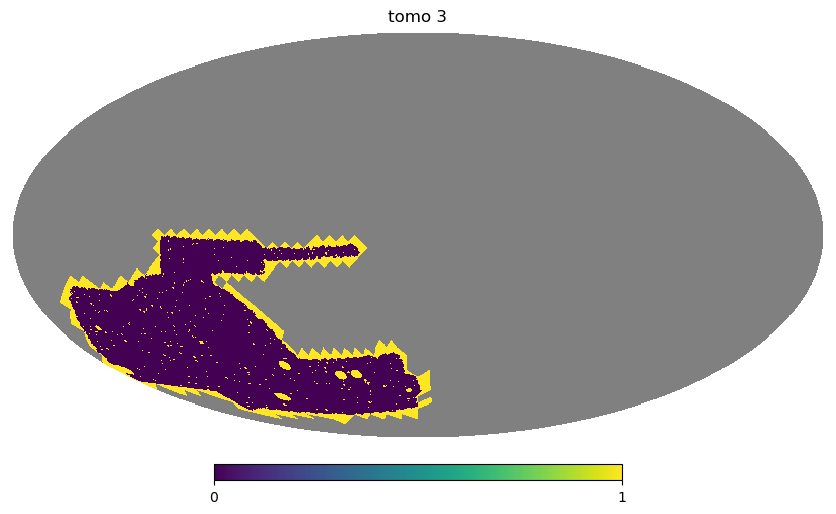

In [14]:
i_pert = 0
for i_tomo in range(n_z_bins):
    kg = x[0].numpy()[i_pert,:,i_tomo]
    print(kg.shape)

    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = kg

    # hp.mollview(hp_map, nest=True, title=f"tomo {i_tomo}")

    hp_mask = np.full(n_pix, hp.UNSEEN)
    hp_mask[hp_map == 0] = 1
    hp_mask[(hp_map != 0) & (hp_map != hp.UNSEEN)] = 0

    hp.mollview(hp_mask, nest=True, title=f"tomo {i_tomo}")

### check smoothed maps

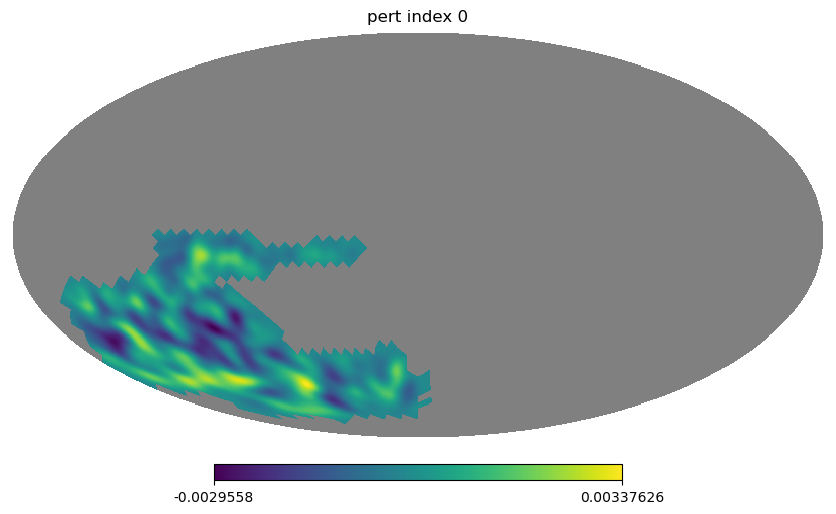

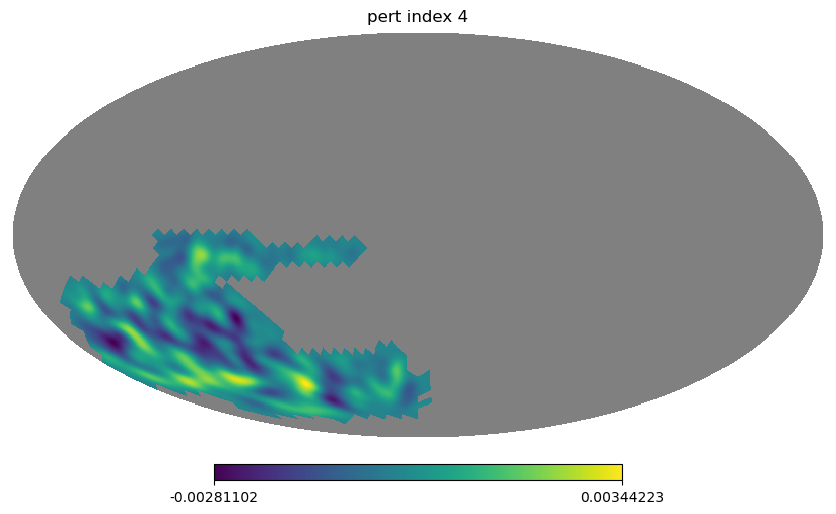

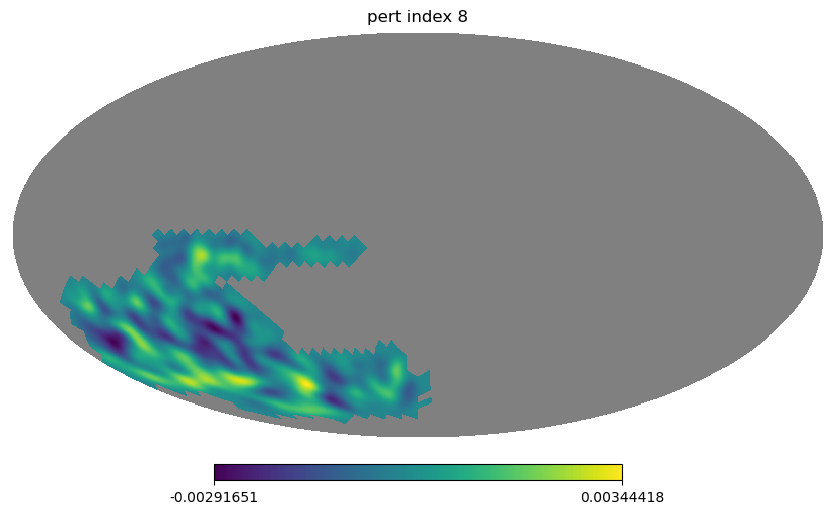

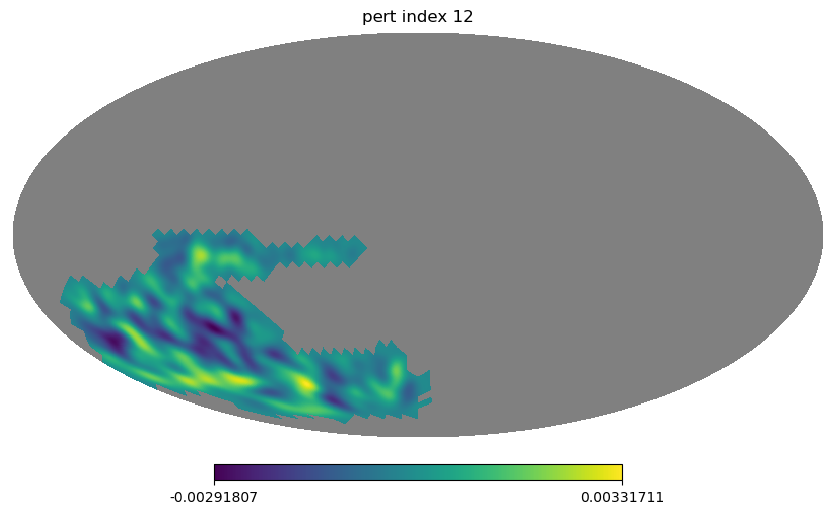

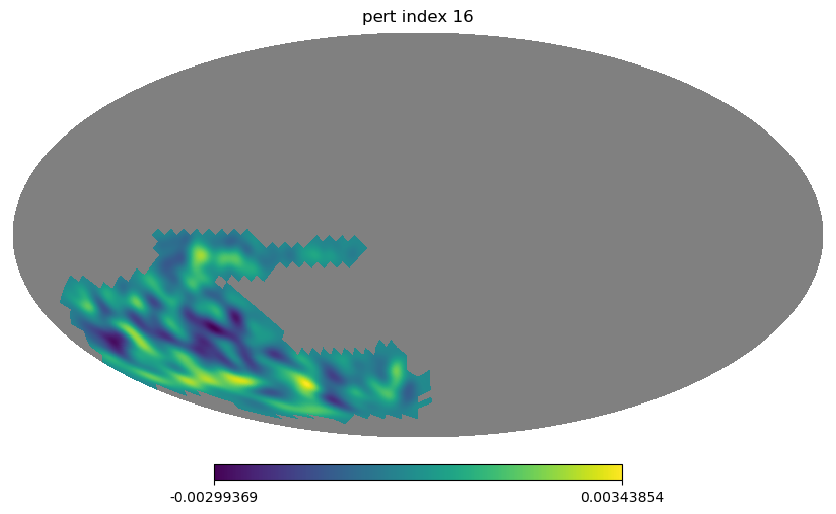

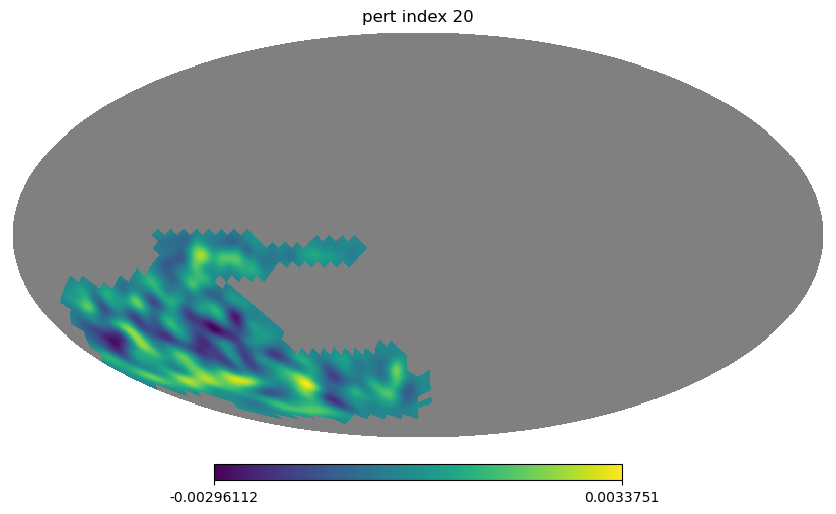

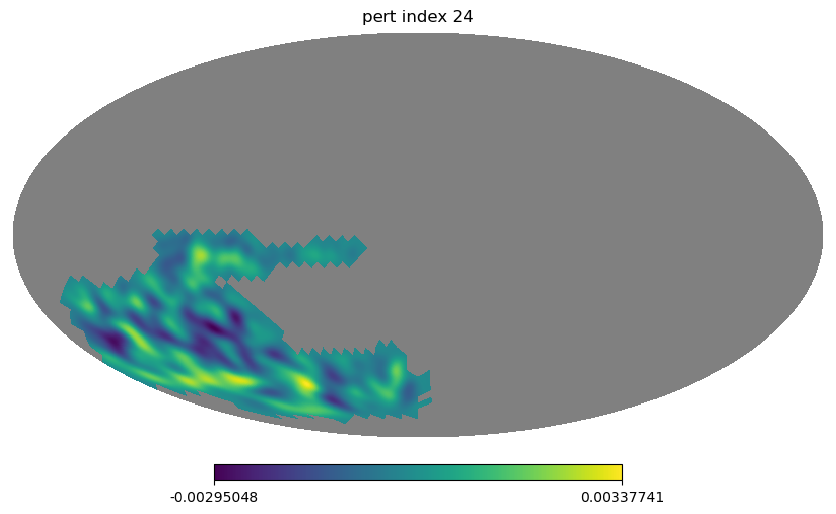

In [15]:
i_tomo = 3

for i_pert in range(0, n_perts*batch_size, batch_size):
    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = x[0].numpy()[i_pert,:,i_tomo]

    hp_map_ring = hp.pixelfunc.reorder(hp_map, inp="NESTED", out="RING")
    hp_smoothed = hp.sphtfunc.smoothing(hp_map_ring, fwhm=0.1)
    hp.mollview(hp_smoothed, title=f"pert index {i_pert}")

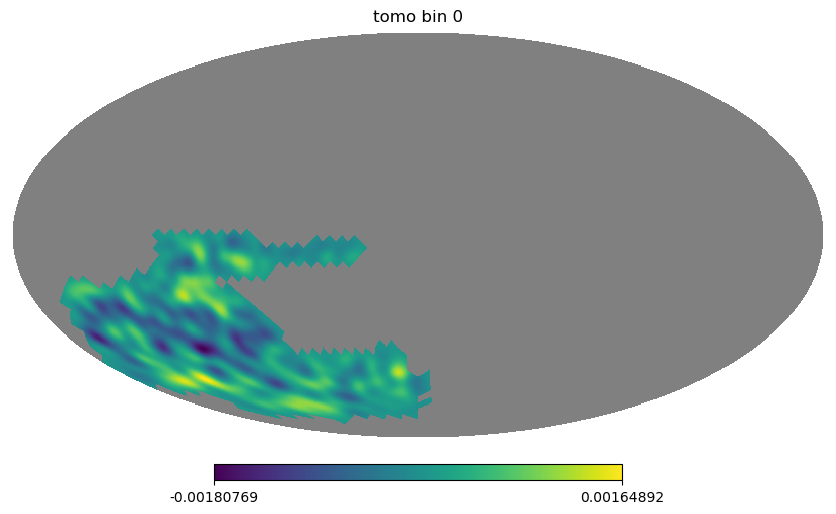

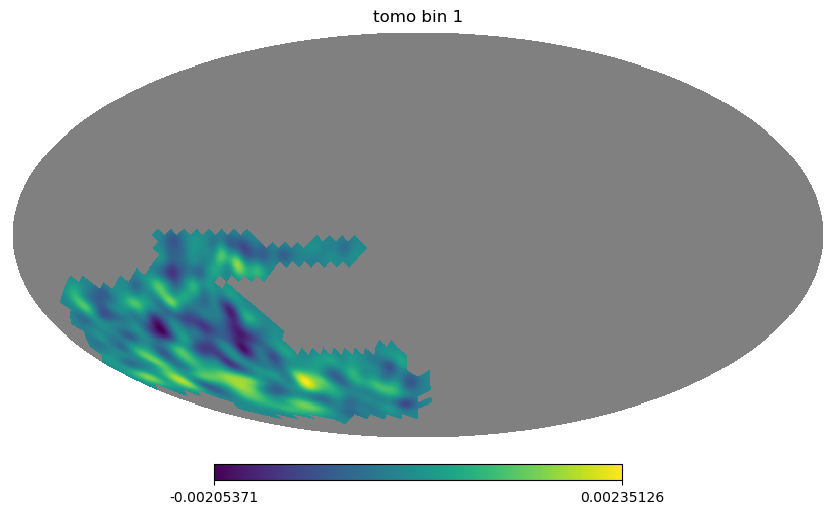

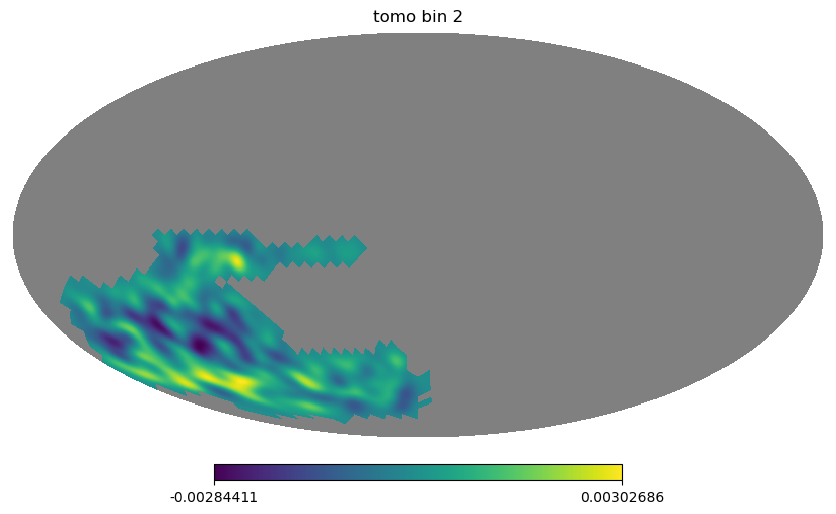

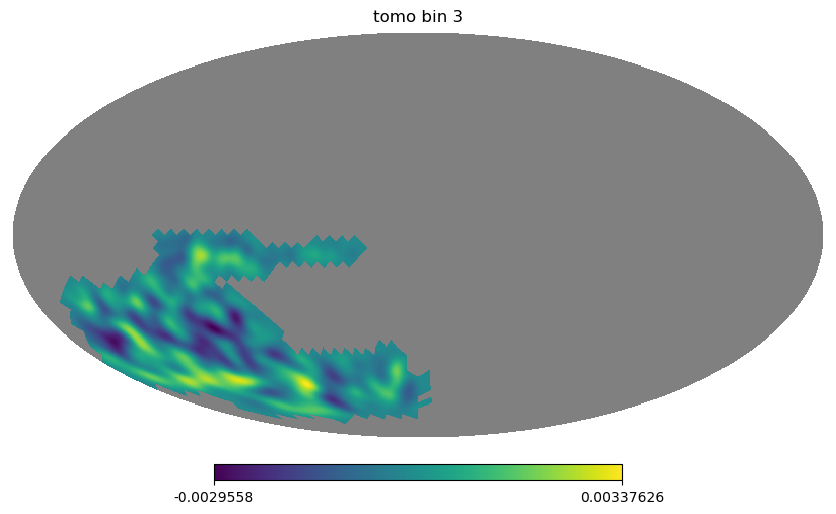

In [16]:
i_pert = 0

for i_tomo in range(n_z_bins):
    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = x[0].numpy()[i_pert,:,i_tomo]

    hp_map_ring = hp.pixelfunc.reorder(hp_map, inp="NESTED", out="RING")
    hp_smoothed = hp.sphtfunc.smoothing(hp_map_ring, fwhm=0.1)
    hp.mollview(hp_smoothed, title=f"tomo bin {i_tomo}")